### **0. Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* You can create a cell above the current one by pressing A, or below by pressing B. This only works in command mode (press Esc when editing).
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some reuslts.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.

In [99]:
# This configures the notebook to automatically reload code when it is changed in imported functions.
%reload_ext autoreload
%autoreload 2

# Import all we need
import numpy as np
from matplotlib import pyplot as plt

from utils import plotCase, loadDataSet, selectTrainingSamples, calcConfusionMatrix, calcAccuracy, plotResultDots, plotResultsOCR
from classifiers import kNN

plt.rcParams['figure.facecolor']='white'

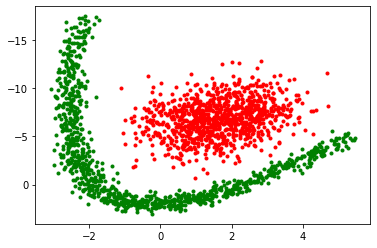

In [100]:
## Select which data to use:

# 1 = dot cloud 1
# 2 = dot cloud 2
# 3 = dot cloud 3
# 4 = OCR data

dataSetNr = 2  # Change this to load new data

# X - Data samples
# D - Desired output from classifier for each sample
# L - Labels for each sample
X, D, L = loadDataSet(dataSetNr)

# You can plot and study dataset 1 to 3 by running:
if dataSetNr in [1,2,3]:
    plotCase(X,L)

In [101]:
# Select a subset of the training samples
numBins = 5                     # Number of bins you want to divide your data into

# For dataSet 1,2,3 I've used 100 samples/bin and for set 4 50 samples/bin
# Bigger sample sizes makes calculations really slow, maybe gigabad code I guess?
numSamplesPerLabelPerBin = np.inf  # Number of samples per label per bin, set to inf for max number (total number is numLabels*numSamplesPerBin)
selectAtRandom = True           # true = select samples at random, false = select the first features

# Split data into bins based on the settings above.
# The outputs are lists of length numBins, where each item is a data array. Try printing for example XBins[0].shape.
XBins, DBins, LBins, numSamplesPerLabelPerBin = selectTrainingSamples(X, D, L, numSamplesPerLabelPerBin, numBins, selectAtRandom)

# To extract a single bin from them use e.g.:
# XBin0 = XBins[0]
# Or to combine several bins into one matrix (good for cross validataion), use the numpy function concatenate:
# XBinComb = np.concatenate(XBins[0:4])
# This example combines 4 bins, nr 0 to 3.

# Add your own code to setup data for training and test here
XTrain = XBins[0]
LTrain = LBins[0]
XTest  = XBins[numBins-2]
LTest  = LBins[numBins-2]

In [102]:
# Select a value for k, either ...

# ... set it manually
# k = 1

# ... or find an optimal value using cross-validation (skip this until you have a working implementation of kNN)

### cross-validation - one bin for validation, one for testing (testing-bin not used here) ###

kSum = np.zeros(numSamplesPerLabelPerBin)
for validationIndex in range(numBins - 1):
    XValid = XBins[validationIndex]
    LValid = LBins[validationIndex]
    XTrain = np.concatenate([XBins[(validationIndex + i + 1) % (numBins - 1)] for i in range(numBins-2)])
    LTrain = np.concatenate([LBins[(validationIndex + i + 1) % (numBins - 1)] for i in range(numBins-2)])

    for k in range(1, numSamplesPerLabelPerBin):
        LPredValid = kNN(XValid, k, XTrain, LTrain)
        cM = calcConfusionMatrix(LPredValid, LValid)
        acc = calcAccuracy(cM)
        kSum[k] += acc
        
    print('Complete: ', (validationIndex + 1) * (100/(numBins-1)), '%')

k = np.argmax(kSum) # The k that gave the highest avg. acc. (smallest one if multiple with same acc.)
print("Optimal k =", k)

# Use optimal k on test data with all training data combined
XTrain = np.concatenate(XBins[0:numBins-1])
LTrain = np.concatenate(LBins[0:numBins-1])
LPredTest = kNN(XTest, k, XTrain, LTrain)
cM = calcConfusionMatrix(LPredTest, LTest)
acc = calcAccuracy(cM)
print("Testdata confusion matrix with k: ", k)
print(cM)
print(f'Testdata accuracy with optimal k: {acc:.4f}')

Complete:  25.0 %
Complete:  50.0 %
Complete:  75.0 %
Complete:  100.0 %
Optimal k = 1
Testdata confusion matrix with k:  1
[[200.   0.]
 [  0. 200.]]
Testdata accuracy with optimal k: 1.0000


In [103]:
# Use kNN to classify data
# Note: you have to modify the kNN() function in classifiers.py yourself.

# Classify training data
LPredTrain = kNN(XTrain, k, XTrain, LTrain)
# Classify test data
LPredTest  = kNN(XTest , k, XTrain, LTrain)

In [104]:
# Calculate The Confusion Matrix and the Accuracy
# Note: you have to modify the calcConfusionMatrix() and calcAccuracy() functions in utils.py yourself.

# The confusion matrix
cM = calcConfusionMatrix(LPredTest, LTest)

# The accuracy
acc = calcAccuracy(cM)

# Print the results
print("Confusion matrix:")
print(cM)
print(f'Accuracy: {acc:.4f}')

Confusion matrix:
[[200.   0.]
 [  0. 200.]]
Accuracy: 1.0000


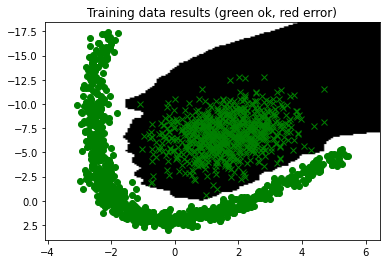

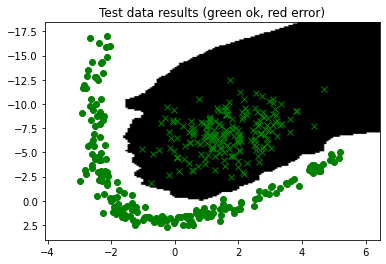

In [105]:
# Plot classifications
# Note: You should not have to modify this code

if dataSetNr < 4:
    plotResultDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, 'kNN', [], k)
else:
    plotResultsOCR(XTest, LTest, LPredTest)